# Kaggle Competition

## Installing required libraries and downloading the dataset
Note that the location of where the `kaggle` library is installed might differ. Change that as you need.

In [4]:
# !pip install kaggle
# !~/.local/bin/kaggle competitions download -c tensorflow-great-barrier-reef
# !pip install numpy
# !pip install opencv-python
# !pip install tensorflow

## Importing required libraries
Another note: `greatbarrierreef` library requires you to have `python 3.7.10`. If you have `python 3.7.10` and you have a folder in your current directory called `greatbarrierreef` then, you can uncomment the library import below.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns

import utils

sns.set_style('darkgrid')

from PIL import Image, ImageDraw
import tensorflow as tf
import tensorflow_hub as tfhub
from keras import backend as K
import tensorflow.keras.optimizers as KO
from keras.layers import *
from keras import Sequential
from keras.models import Model
import numpy as np 
import pandas as pd
import shutil as sh
from PIL import Image
from tqdm.auto import tqdm

import os
import ast  ## Change str -> list.
import sys
import time
import random

import warnings

INPUT_DIR = '/home/peshmerge/.kaggle/tensorflow-great-barrier-reef/'
INPUT_DIR_COCO_STYLE = os.path.join(INPUT_DIR,'coco_style/')
sys.path.insert(0, INPUT_DIR)
IMAGE_PATH = f'{INPUT_DIR}/train_images'
TRAIN_DATA_CROPPED_DIR= '/home/peshmerge/.kaggle/tensorflow-great-barrier-reef/train_images_cropped/'

## Reading the training data

In [51]:
df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df_train['img_path'] = os.path.join(INPUT_DIR, 'train_images') + "/video_" + df_train.video_id.astype(str)+"/"+ df_train.video_frame.astype(str)+".jpg"

df_train['annotations'] = df_train['annotations'].apply(ast.literal_eval)
df_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path
0,0,40258,0,0,0-0,[],/home/peshmerge/.kaggle/tensorflow-great-barri...
1,0,40258,1,1,0-1,[],/home/peshmerge/.kaggle/tensorflow-great-barri...
2,0,40258,2,2,0-2,[],/home/peshmerge/.kaggle/tensorflow-great-barri...
3,0,40258,3,3,0-3,[],/home/peshmerge/.kaggle/tensorflow-great-barri...
4,0,40258,4,4,0-4,[],/home/peshmerge/.kaggle/tensorflow-great-barri...


In [4]:
mask_with_annotations = df_train['annotations'].map(len) != 0
mask_without_annotations = df_train['annotations'].map(len) == 0
cnt_with_annotation = len(df_train[mask_with_annotations])
cnt_without_annotation = len(df_train[mask_without_annotations])
print('Images with annotations:', cnt_with_annotation)
print('Images without annotations:', cnt_without_annotation)

Images with annotations: 4919
Images without annotations: 18582


In [52]:
df_annotated = df_train[df_train['annotations'].map(len) != 0]
df_annotated.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/home/peshmerge/.kaggle/tensorflow-great-barri...
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/home/peshmerge/.kaggle/tensorflow-great-barri...
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",/home/peshmerge/.kaggle/tensorflow-great-barri...
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",/home/peshmerge/.kaggle/tensorflow-great-barri...
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",/home/peshmerge/.kaggle/tensorflow-great-barri...


In [73]:
df_annotated = df_annotated.sample(frac=1)

coco_style_df = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h', 'x_center', 'y_center', 'classes'])
x, y, w, h = [], [], [], []
index_1000 = 1
names_list = []
for index, row in df_annotated.iterrows():
    if index_1000 > 100:
        break
    annotations_list = row['annotations']
    image_path = row['img_path']
    for item in annotations_list:
        x.append(item['x'])
        y.append(item['y'])
        w.append(item['width'])
        h.append(item['height'])
        names_list.append('video_' + str(row['video_id']) + '_' + str(row['video_frame']))
    index_1000 += 1

coco_style_df['image_id'] = names_list
coco_style_df['x'] = x
coco_style_df['y'] = y
coco_style_df['w'] = w 
coco_style_df['h'] = h

coco_style_df['classes'] = 0
coco_style_df['x_center'] = coco_style_df['x'] + coco_style_df['w'] / 2
coco_style_df['y_center'] = coco_style_df['y'] + coco_style_df['h'] / 2

coco_style_df = coco_style_df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
index = list(set(coco_style_df.image_id))
coco_style_df.to_csv(os.path.join(INPUT_DIR_COCO_STYLE,'coco_style.csv'), index=False)


In [74]:
def get_image_path_from_name(image_id):
    folder,folder_id, image_name = image_id.split('_')
    image_path = os.path.join(INPUT_DIR,'train_images',(folder+'_'+folder_id),image_name) +'.jpg'
    return image_path

In [75]:
train_instances = 0
validation_instances = 0
if True:
    for fold in [0]:
        val_index = index[len(index) * fold // 5:len(index) * (fold + 1) // 5]
        for name, mini in tqdm(coco_style_df.groupby('image_id')):
            if True or name == 'video_0_1003':
                # print(mini)
                if name in val_index:
                    path2save = 'validation/'
                    validation_instances += 1
                else:
                    path2save = 'training/'
                    train_instances += 1
                if not os.path.exists(INPUT_DIR_COCO_STYLE + 'convertor/labels/' + path2save):
                    os.makedirs(INPUT_DIR_COCO_STYLE + 'convertor/labels/' + path2save)
                with open(INPUT_DIR_COCO_STYLE + 'convertor/labels/' + path2save + name + ".txt", 'w+') as f:
                    row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
                    image_path = get_image_path_from_name(name)
                    check_image_width_height = Image.open(image_path)
                    img_width, img_height = check_image_width_height.size
                    # print("row")
                    # print(row)
                    for r in (row):
                        r[1] = r[1]/img_width
                        r[2] = r[2]/img_height
                        r[3] = r[3]/img_width
                        r[4] = r[4]/img_height
                    row = row.astype(str)
                    # print("str ")
                    # print(row)
                    for j in range(len(row)):
                        # print(row[j], 'n')
                        row[j][0] = str(int(float(row[j][0])))
                        text = ' '.join(row[j])
                        # print("Before writing ")
                        # print(text)
                        f.write(text)
                        f.write("\n")
                if not os.path.exists(INPUT_DIR_COCO_STYLE + 'convertor/images/{}'.format(path2save)):
                    os.makedirs(INPUT_DIR_COCO_STYLE + 'convertor/images/{}'.format(path2save))
                sh.copy(get_image_path_from_name(name), INPUT_DIR_COCO_STYLE +'convertor/images/{}/{}.jpg'.format(path2save, name))
print('{} validation instances'.format(validation_instances))
print('{} training instances'.format(train_instances))

100%|██████████| 100/100 [00:00<00:00, 173.99it/s]

20 validation instances
80 training instances


In [76]:
!python train.py --single-cls --img 1280 --rect --batch 8 --epochs 50 --data coco.yml --weights weights/yolov5n6.pt


train: weights=weights/yolov5n6.pt, cfg=, data=coco.yml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=8, imgsz=1280, rect=True, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=True, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 3 (delta 2), pack-reused 2
Unpacking objects: 100% (5/5), 2.35 KiB | 126.00 KiB/s, done.
From https://github.com/ultralytics/yolov5
   9708cf5..4e841b9  master     -> origin/master
⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6

### Visualizing the dataset


In [6]:
# Fetch the image with most cots in one image
image_id_most_cots = df_train.sort_values(by='annotations', key=lambda x: x.map(len), ascending=False).iloc[0].image_id
print(image_id_most_cots)

1-9115


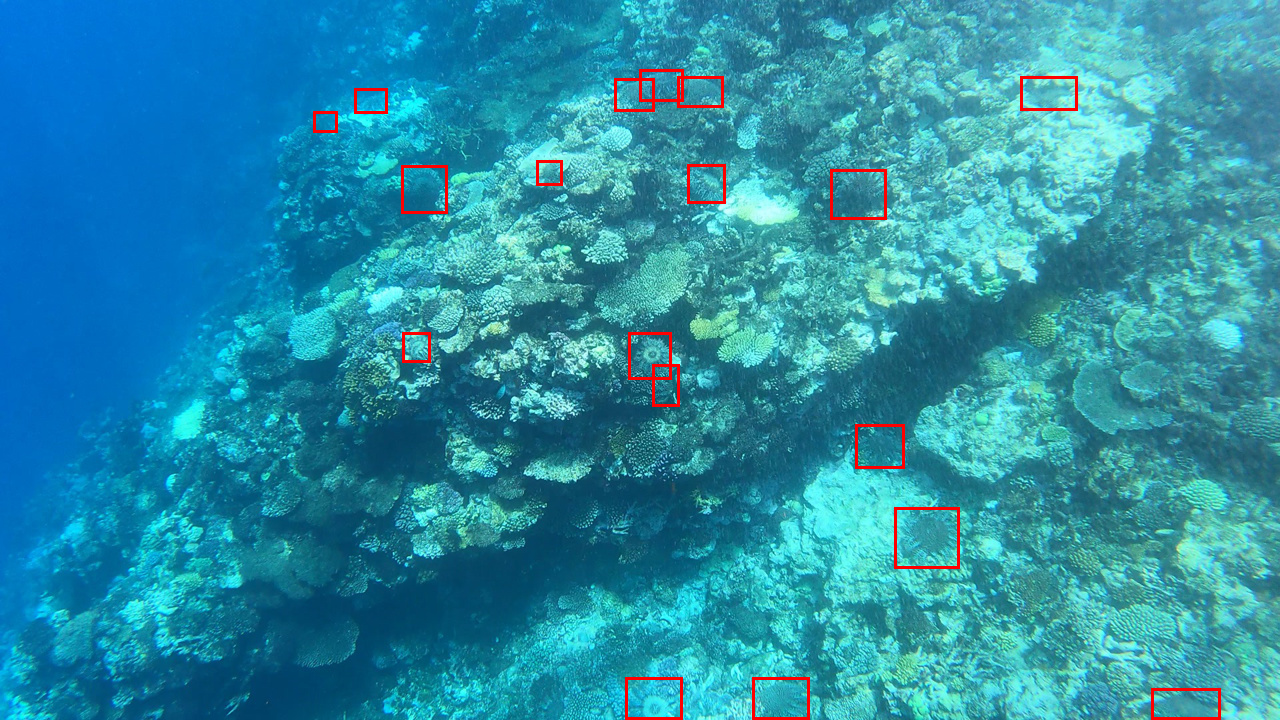

In [7]:
def show_image(df, image_id=None, video_id=None, video_frame=None):
    if image_id:
        video_id, video_frame = image_id.split('-')
        video_id, video_frame = int(video_id), int(video_frame)
        row = df[df['image_id'] == image_id].iloc[0]
    else:
        row = df[df['video_id'] == video_id & df['video_frame'] == video_frame].iloc[0]

    im = Image.open(f'{IMAGE_PATH}/video_{video_id}/{video_frame}.jpg')
    draw = ImageDraw.Draw(im)

    for box in row.annotations:
        shape = (box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height'])
        draw.rectangle(shape, outline='red', width=3)
    display(im)

show_image(df_train, image_id_most_cots)

## Preprocessing the Data
Steps taken:
1. Crop all the images with annotation to only get the Starfish samples.
2. Resize the images to 200x200 with upscaling using Lanczos method.
3. (WIP) Apply data augmentations:
    - Rotation
    - Segmentation
4. Saving all cropped images into a directory to use them later on

In [8]:
# img_data = []
# df_annotated.head()

# for img_id in tqdm(df_annotated.index, position=0, leave=True):
#     image_path = df_annotated['img_path'][img_id]
#     img = Image.open(image_path)
#     # print(df_annotated['annotations'])
#     box_id = 0
#     for box in df_annotated['annotations'][img_id]:
#         area = [int(box['x']), int(box['y']), int(box['x']) +
#                 int(box['width']), int(box['y']) + int(box['height'])]
#         cropped_img = img.crop(area).resize(
#             (200, 200), resample=Image.ANTIALIAS)
#         pil_image = cropped_img.convert('RGB')
#         # Image name is the name of the folder with the image name + detection box 
#         image_name = (image_path[image_path.find('video_'):-4]).replace('/','_') +'_box_'+ str(box_id) + '.jpg'
#         pil_image.save(os.path.join(TRAIN_DATA_CROPPED_DIR,image_name))
#         open_cv_image = np.array(pil_image)
#         img_data.append(open_cv_image)
#         box_id +=1

# img_data = np.array(img_data)
